# Plot Dice Means from Sweep

## Setup

In [1]:
# imports
import csv
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from pathlib import Path
import re


In [2]:
# config
ROOT = '/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches'
SUBTYPES = ['ALL'] # ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']
EXCLUDE_SUBTYPES = []
OUTPUT_DIR = None
ASCENDING = False # sort x-axis lowest to highest if True
SAVE_SUMMARY_CSV = False
PLOT_COMBINED = True # plot combined curve for all subtypes in one plot


## Classes and functions

In [3]:
@dataclass
class MeanPoint:
    train_count: int # number of training samples for finetuning
    mean_dice: float # mean dice score
    eval_count: int # number of eval samples
    csv_path: Path # path to csv file with metrics


In [4]:
# function to find subtypes 
def find_subtypes(root, requested, exclude=None):
    
    # if all requested, find all subtypes
    if any(s.upper() == 'ALL' for s in requested):
        subtypes = sorted([d.name for d in root.iterdir() if d.is_dir()])

        # exclude if needed
        if exclude:
            subtypes = [s for s in subtypes if s not in set(exclude)]

        return subtypes

    # otherwise, return requested subtypes
    return requested


In [5]:
# function to parse counts from filename
def parse_counts_from_filename(filename):

    # regex
    COUNT_RE = re.compile(r'count_tr(\d+)_ev(\d+)')

    # search
    match = COUNT_RE.search(filename)
    if not match:
        return None
    return int(match.group(1)), int(match.group(2))


In [6]:
# function to read mean dice from CSV
def read_mean_dice_from_csv(csv_path):

    try:
        # open file
        with open(csv_path, 'r', newline='') as f:

            # read mean dice from file
            reader = csv.DictReader(f)
            for row in reader:
                if row.get('filename').lower() == 'mean':
                    try:
                        return float(row['dice_050'])
                    except Exception:
                        return None

    except FileNotFoundError:
        return None
    
    return None


In [7]:
# scan subtypes preds for metrics csv and build list
def collect_subtype_points(preds_dir):

    # list to hold points
    points = []

    # iterate over csv files in preds_dir
    for p in preds_dir.glob('metrics_test_*.csv'):
        counts = parse_counts_from_filename(p.name)

        # skip nonconforming files
        if not counts:
            continue

        # read mean dice
        train, eval = counts
        mean_dice = read_mean_dice_from_csv(p)

        # skip if mean dice not found
        if mean_dice is None or np.isnan(mean_dice):
            continue

        # create MeanPoint and add to list
        points.append(MeanPoint(train_count=train, mean_dice=float(mean_dice), eval_count=eval, csv_path=p))

    # return list of points
    return points


## Plotting

In [8]:
# function to plot curve
def plot_subtype_curve(subtype, points, outdir=None, ascending=False):

    # return if no points
    if not points:
        print(f'[WARN] No points to plot for {subtype}. Skipping.')
        return None
    
    # sort points by train_count
    points = sorted(points, key=lambda r: r.train_count, reverse=not ascending)

    # extract data for plotting
    xs = [r.train_count for r in points]
    ys = [r.mean_dice for r in points]

    # create plot
    plt.figure(figsize=(8, 6))
    plt.plot(xs, ys, marker='o')

    # x ticks
    ax = plt.gca()
    ax.set_xticks(range(min(xs), max(xs)+1, 1))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not ascending:
        ax.invert_xaxis()


    # label
    plt.xlabel('Train count (num finetune patches)')
    plt.ylabel('Mean dice @0.5 (eval set)')
    plt.title(f'{subtype}: Dice vs. train_count')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # show plot
    plt.show()

    # save plot
    if outdir is not None:
        outpath = outdir / f'{subtype}_dice_vs_train_count.png'
        plt.savefig(outpath)
        return outpath


In [9]:
# function to plot all subtypes
def plot_all_subtypes(subtype_to_points, outdir=None, ascending=False):

    # filter to subtypes with at least 1 point
    filtered = {k: v for k, v in subtype_to_points.items() if v}
    if not filtered:
        print('[WARN] No subtypes with points to plot. Skipping combined plot.')
        return None
    
    # create plot
    plt.figure(figsize=(10, 6))

    # sort within each subtype by train_count
    for subtype, points in filtered.items():
        points_sorted = sorted(points, key=lambda r: r.train_count, reverse=not ascending)
        xs = [r.train_count for r in points_sorted]
        ys = [r.mean_dice for r in points_sorted]
        plt.plot(xs, ys, marker='o', label=subtype)

    # x ticks
    ax = plt.gca()
    all_xs = [r.train_count for points in filtered.values() for r in points]
    ax.set_xticks(range(min(all_xs), max(all_xs)+1, 1))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not ascending:
        ax.invert_xaxis()

    # label
    plt.xlabel('Train count (num finetune patches)')
    plt.ylabel('Mean dice @0.5 (eval set)')
    plt.title('Dice vs. train_count for all subtypes')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()

    # show plot    
    plt.show()

    # save plot
    if outdir is not None:
        outpath = outdir / 'all_subtypes_dice_vs_train_count.png'
        plt.savefig(outpath)
        return outpath


[INFO] Found subtypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']


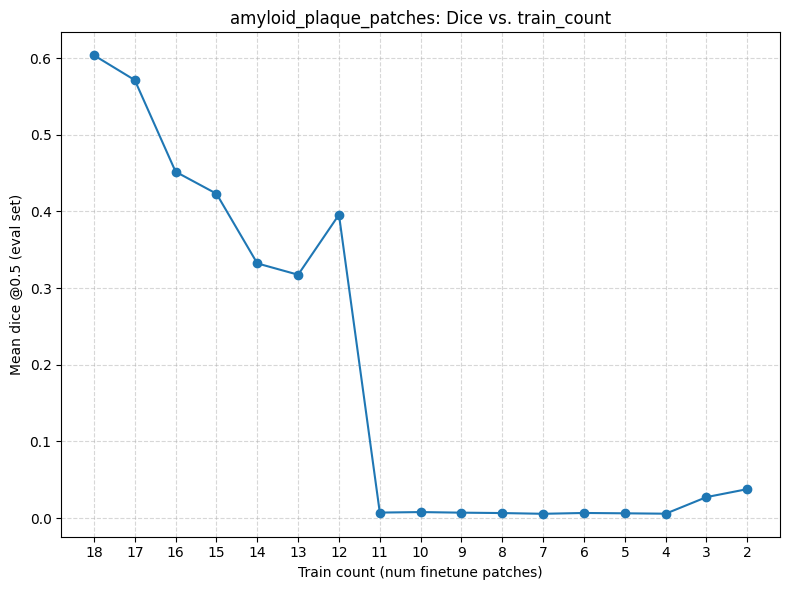

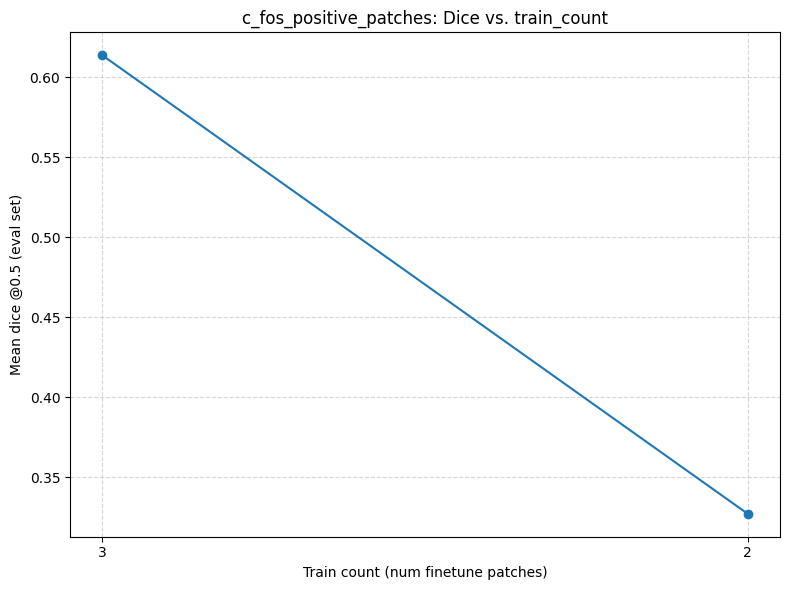

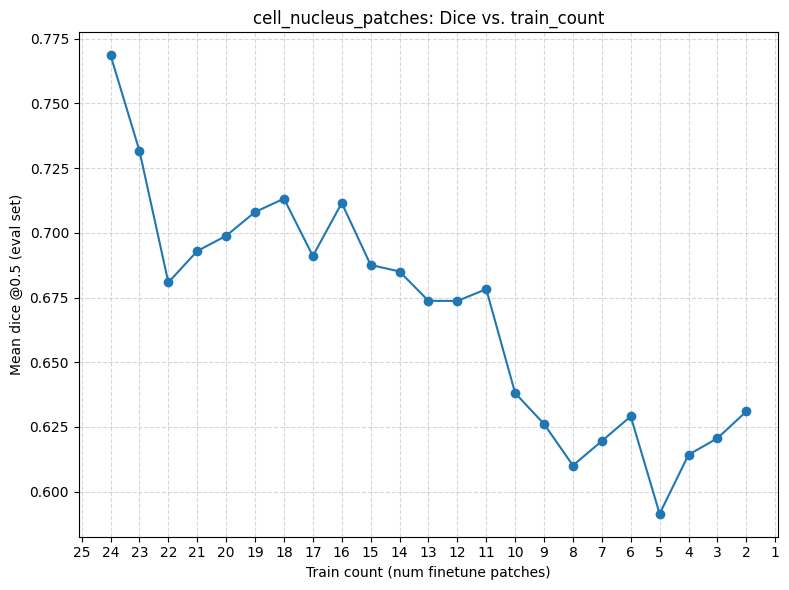

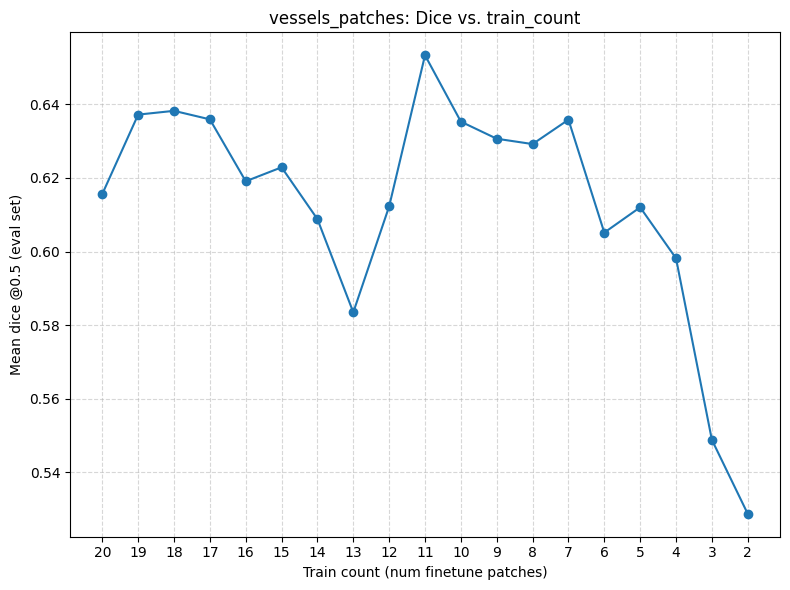

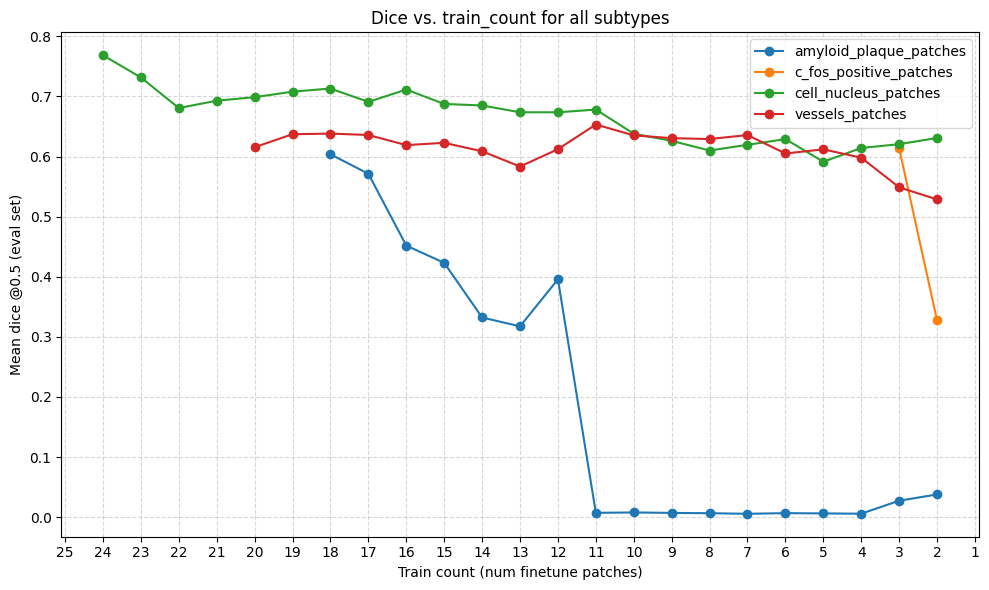

In [10]:
# resolve paths
root = Path(ROOT)
outdir = Path(OUTPUT_DIR) if OUTPUT_DIR is not None else None
# outdir.mkdir(parents=True, exist_ok=True)

# find subtypes
subtypes = find_subtypes(root, SUBTYPES, EXCLUDE_SUBTYPES)
print(f'[INFO] Found subtypes: {subtypes}')

# optionally gather summary csv across all subtypes
summary_rows = []

# keep mapping for combined plot
subtype_to_points = {}

# process each subtype
for subtype in subtypes:
    preds_dir = root / subtype / 'preds'
    if not preds_dir.exists():
        print(f'[WARN] Missing preds dir: {preds_dir}. Skipping subtype {subtype}.')
        continue

    # collect points (train_count, mean_dice, eval_count)
    points = collect_subtype_points(preds_dir)
    if not points:
        print(f'[WARN] No metrics with MEAN found in {preds_dir}. Skipping subtype {subtype}.')
        continue

    # save for combined plot if needed
    subtype_to_points[subtype] = points

    # accumulate rows for the combined summary csv
    for r in points:
        summary_rows.append({
            'subtype': subtype,
            'train_count': str(r.train_count),
            'eval_count': str(r.eval_count),
            'mean_dice_050': f'{r.mean_dice:.6f}',
            'metrics_csv': str(r.csv_path)
        })

    # plot curve for this subtype
    plot_subtype_curve(subtype, points, ascending=ASCENDING)


# plot combined curve if requested
if PLOT_COMBINED and subtype_to_points:
    plot_all_subtypes(subtype_to_points, ascending=ASCENDING)

# save combined summary csv if requested
if SAVE_SUMMARY_CSV and summary_rows:
    summary_csv = outdir / 'dice_vs_traincount_summary.csv'
    with open(summary_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['subtype', 'train_count', 'eval_count', 'mean_dice_050', 'metrics_csv'])
        writer.writeheader()
        writer.writerows(summary_rows)
    print(f'[INFO] Saved summary CSV to {summary_csv}')
